In [1]:
import geopandas as gpd
import shapely.geometry as Point
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from datetime import datetime, timedelta

In [10]:
# Get all postcodes for local area
LOCAL_LAT = 51.5146
LOCAL_LNG = -2.5820
RADIUS_METRES = 2000 # 2km within the central point for local city
MONTHS = 6 # Number of months to pull data rom

In [23]:
# API helper - Current Police API has a rate limit of 15 requests per second with a burst of 30
def get_api_response(url, retries = 5, backoff=1):
    for i in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print(f"You have exceeded the rate limit. Waiting {backoff} seconds...")
            time.sleep(backoff)
            backoff *= 2
        else:
            print(f"Error {response.status_code} - {response.text}")
            return None
    return None

In [24]:
def fetch_local_postcodes(lat, lng, radius=2000):
    postcode_url = f"https://api.postcodes.io/postcodes?lon={lng}&lat={lat}&radius={radius}"
    print("Fetching nearby postcodes...")
    data = get_api_response(postcode_url)
    
    if not data:
        return []
    return [p['postcode'] for p in data['result']]

In [14]:
def get_lat_lng(postcode):
    url = f"https://api.postcodes.io/postcodes/{postcode}"
    result = get_api_response(url)
    if result and result.get('result'):
        return result['result']['latitude'], result['result']['longitude']
    return None, None

In [15]:
# Get data for past N months
def generate_months(n):
    base = datetime.today().replace(day=1)
    return [(base - timedelta(days=30 * i)).strftime("%Y-%m") for i in range(n)]

In [ ]:
# List of Bristol area outcodes (first half of postcode)
outcodes = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6', 'BS7', 'BS8', 'BS9', 'BS10', 'BS11', 'BS13', 'BS14', 'BS15', 'BS16', 'BS30', 'BS34']


def fetch_crime_data(postcodes, months):
    all_crimes = []
    lat_lng_cache = {}

    for postcode in postcodes:
        lat, lng = lat_lng_cache.get(postcode, (None, None))
        if not lat:
            lat, lng = get_lat_lng(postcode)
            lat_lng_cache[postcode] = (lat, lng)
        if not lat:
            print(f"Couldn't get location for {postcode}, skipping.")
            continue

        for month in months:
            url = f"https://data.police.uk/api/crimes-street/all-crime?lat={lat}&lng={lng}&date={month}"
            print(f"Fetching crimes for {postcode} ({month})")
            crimes = get_api_response(url)
            if crimes:
                for crime in crimes:
                    crime['postcode'] = postcode
                    crime['month'] = month
                all_crimes.extend(crimes)
            time.sleep(0.2)  # Rate limit protection

    return all_crimes

In [25]:
postcodes = fetch_local_postcodes(LOCAL_LAT, LOCAL_LNG, RADIUS_METRES)
months = generate_months(MONTHS)
crime_data = fetch_crime_data(postcodes, months)


Fetching nearby postcodes...
Fetching crimes for BS34 7QS (2025-05)
Error 404 - 
Fetching crimes for BS34 7QS (2025-04)
Fetching crimes for BS34 7QS (2025-03)
Fetching crimes for BS34 7QS (2025-01)
Fetching crimes for BS34 7QS (2025-01)
Fetching crimes for BS34 7QS (2024-12)
Fetching crimes for BS34 7BA (2025-05)
Error 404 - 
Fetching crimes for BS34 7BA (2025-04)
Fetching crimes for BS34 7BA (2025-03)
Fetching crimes for BS34 7BA (2025-01)
Fetching crimes for BS34 7BA (2025-01)
Fetching crimes for BS34 7BA (2024-12)
Fetching crimes for BS34 7QQ (2025-05)
Error 404 - 
Fetching crimes for BS34 7QQ (2025-04)
Fetching crimes for BS34 7QQ (2025-03)
Fetching crimes for BS34 7QQ (2025-01)
Fetching crimes for BS34 7QQ (2025-01)
Fetching crimes for BS34 7QQ (2024-12)
Fetching crimes for BS34 7QB (2025-05)
Error 404 - 
Fetching crimes for BS34 7QB (2025-04)
Fetching crimes for BS34 7QB (2025-03)
Fetching crimes for BS34 7QB (2025-01)
Fetching crimes for BS34 7QB (2025-01)
Fetching crimes for BS

In [28]:
# Save to file
df = pd.DataFrame(crime_data)
df.to_csv("../data/filton_crime_data.csv", index=False)
print("Crime data saved to ../data/filton_crime_data.csv")
df.head()

Crime data saved to ../data/filton_crime_data.csv


,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,postcode
0,anti-social-behaviour,Force,"{'latitude': '51.504003', 'street': {'id': 227...",,None,,126954826,,2025-03,BS34 7QS
1,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",,None,,126954994,,2025-03,BS34 7QS
2,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",,None,,126955680,,2025-03,BS34 7QS
3,anti-social-behaviour,Force,"{'latitude': '51.509414', 'street': {'id': 228...",,None,,126955191,,2025-03,BS34 7QS
4,anti-social-behaviour,Force,"{'latitude': '51.500977', 'street': {'id': 227...",,None,,126955944,,2025-03,BS34 7QS


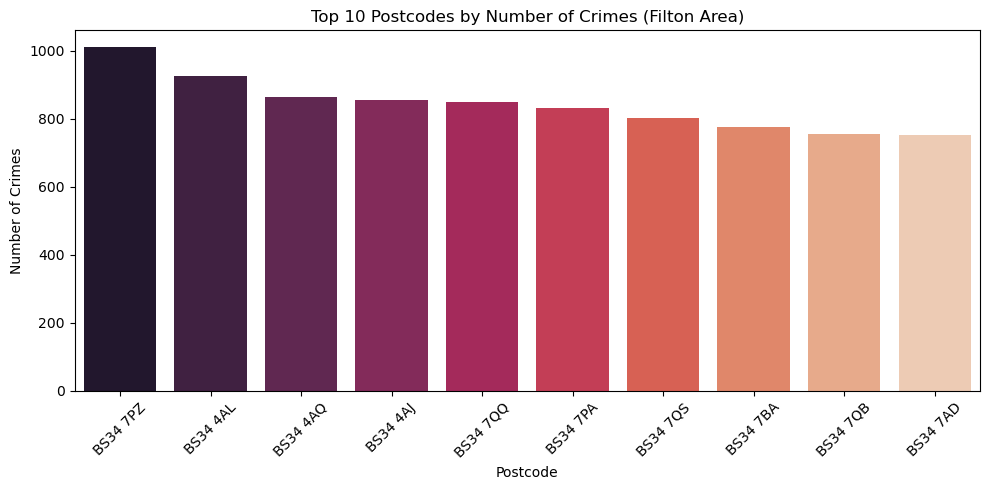

In [29]:
# Top 10 postcodes with most crime
top_postcodes = df['postcode'].value_counts().nlargest(100)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_postcodes.index, y=top_postcodes.values, palette="rocket")
plt.title('Top 10 Postcodes by Number of Crimes (Filton Area)')
plt.xlabel('Postcode')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

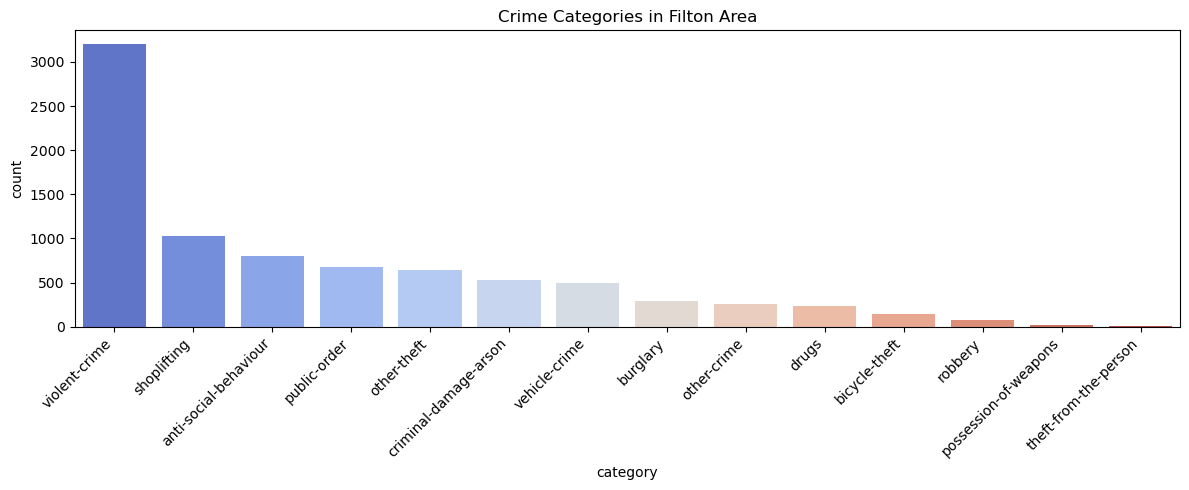

In [30]:
# Crime category vs Number of Crimes
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette="coolwarm")
plt.title('Crime Categories in Filton Area')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [34]:
# Create map centred on Filton
crime_map = folium.Map(location=[LOCAL_LAT, LOCAL_LNG], zoom_start=14)

# Filter out missing data
df = df[df['location'].notnull() & df['location'].apply(lambda loc: loc.get('latitude') and loc.get('longitude'))]

df['lat'] = df['location'].apply(lambda loc: float(loc['latitude']))
df['lng'] = df['location'].apply(lambda loc: float(loc['longitude']))

heat_data = df[['lat', 'lng']].values.tolist()

# Add heat effect to the map
HeatMap(heat_data, radius=15, blur=25, max_zoom=15).add_to(crime_map)

# Save map as HTML
crime_map.save("../assets/filton_crime_map.html")
print("Crime heatmap saved as filton_crime_map.html. Open it in a browser!")

Crime heatmap saved as filton_crime_map.html. Open it in a browser!


In [35]:
# Get all column names
df.columns

Index(['category', 'location_type', 'location', 'context', 'outcome_status',
       'persistent_id', 'id', 'location_subtype', 'month', 'postcode', 'lat',
       'lng'],
      dtype='object')

In [36]:
# Shape
df.shape

(8415, 12)

In [37]:
# Replace empty strings with NaN for uniformity
df_cleaned = df.replace('', np.nan)

# Total number of rows with missing values
df_cleaned.isna().sum()

category               0
location_type          0
location               0
context             8415
outcome_status       800
persistent_id        807
id                     0
location_subtype    8408
month                  0
postcode               0
lat                    0
lng                    0
dtype: int64

In [38]:
# Drop irrelevant columns
df_cleaned = df_cleaned.drop(columns=['outcome_status', 'context', 'persistent_id', 'location_subtype'], axis=1)
df_cleaned.head()

,category,location_type,location,id,month,postcode,lat,lng
0,anti-social-behaviour,Force,"{'latitude': '51.504003', 'street': {'id': 227...",126954826,2025-03,BS34 7QS,51.504003,-2.578959
1,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",126954994,2025-03,BS34 7QS,51.513031,-2.571378
2,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",126955680,2025-03,BS34 7QS,51.513031,-2.571378
3,anti-social-behaviour,Force,"{'latitude': '51.509414', 'street': {'id': 228...",126955191,2025-03,BS34 7QS,51.509414,-2.571967
4,anti-social-behaviour,Force,"{'latitude': '51.500977', 'street': {'id': 227...",126955944,2025-03,BS34 7QS,51.500977,-2.574368


In [39]:
# Regex pattern for YYYY-MM format
pattern = r'^\d{4}-(0[1-9]|1[0-2])$'

# Cound the number of invalid dates
valid_count = (~df_cleaned['month'].str.match(pattern)).sum()
print(f"Number of invalid dates: {valid_count}")

Number of invalid dates: 0


In [14]:
# Seperate Year and Month to different columns
# df_cleaned[["year", "month"]] = df["month"].str.split("-", expand = True)
# df_cleaned.head()

In [40]:
# Count crime categories
crime_category_count = df_cleaned['category'].value_counts()
print(crime_category_count)

violent-crime            3198
shoplifting              1030
anti-social-behaviour     800
public-order              682
other-theft               646
criminal-damage-arson     528
vehicle-crime             494
burglary                  292
other-crime               254
drugs                     234
bicycle-theft             145
robbery                    81
possession-of-weapons      24
theft-from-the-person       7
Name: category, dtype: int64


In [41]:
# Recategorised crimes to imporve generalisation
crime_category_map = {
    'violent-crime': 'violence',
    'robbery': 'violence',
    'shoplifting': 'theft',
    'burglary': 'theft',
    'vehicle-crime': 'theft',
    'bicycle-theft': 'theft',
    'other-theft': 'theft',
    'anti-social-behaviour': 'anti-social',
    'public-order': 'anti-social',
    'criminal-damage-arson': 'anti-social',
    'drugs': 'drugs',
    'possession-of-weapons': 'other', 
    'other-crime': 'other'
}

df_cleaned['recategorised_crimes'] = df_cleaned['category'].map(crime_category_map)

# Assign any unmapped crimes to 'other' category
df_cleaned['recategorised_crimes'] = df_cleaned['recategorised_crimes'].fillna('other')

crime_category_count = df_cleaned['recategorised_crimes'].value_counts()
print(crime_category_count)

violence       3279
theft          2607
anti-social    2010
other           285
drugs           234
Name: recategorised_crimes, dtype: int64


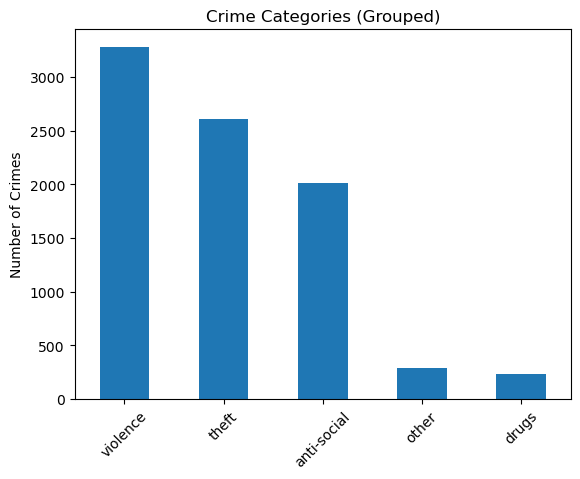

In [42]:
df_cleaned['recategorised_crimes'].value_counts().plot(kind='bar')
plt.title("Crime Categories (Grouped)")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.show()

In [43]:
# Total crimes per postcode
total_crimes_per_postcode = df_cleaned.groupby('postcode').size().reset_index(name='total_crimes')
print(total_crimes_per_postcode)

   postcode  total_crimes
0  BS34 4AJ           855
1  BS34 4AL           924
2  BS34 4AQ           864
3  BS34 7AD           751
4  BS34 7BA           774
5  BS34 7PA           830
6  BS34 7PZ          1009
7  BS34 7QB           756
8  BS34 7QQ           850
9  BS34 7QS           802


In [44]:
# Top crime category per postcode
top_category_per_postcode = (
    df_cleaned.groupby(['postcode', 'recategorised_crimes']).size().reset_index(name='count').sort_values(['postcode', 'count'], ascending=[True, False]).drop_duplicates('postcode').rename(columns={'recategorised_crimes': 'top_crime_category'}).drop('count', axis=1)
)
print(top_category_per_postcode)

    postcode top_crime_category
3   BS34 4AJ              theft
8   BS34 4AL              theft
13  BS34 4AQ              theft
19  BS34 7AD           violence
24  BS34 7BA           violence
29  BS34 7PA           violence
34  BS34 7PZ           violence
39  BS34 7QB           violence
44  BS34 7QQ           violence
49  BS34 7QS           violence


In [45]:
# Crimes per postcode per month
monthly_crime = (
    df_cleaned.groupby(['postcode', 'month'])
    .size()
    .reset_index(name='monthly_crimes')
)
print(monthly_crime)

    postcode    month  monthly_crimes
0   BS34 4AJ  2024-12             214
1   BS34 4AJ  2025-01             410
2   BS34 4AJ  2025-03             231
3   BS34 4AL  2024-12             236
4   BS34 4AL  2025-01             446
5   BS34 4AL  2025-03             242
6   BS34 4AQ  2024-12             215
7   BS34 4AQ  2025-01             416
8   BS34 4AQ  2025-03             233
9   BS34 7AD  2024-12             172
10  BS34 7AD  2025-01             382
11  BS34 7AD  2025-03             197
12  BS34 7BA  2024-12             169
13  BS34 7BA  2025-01             402
14  BS34 7BA  2025-03             203
15  BS34 7PA  2024-12             178
16  BS34 7PA  2025-01             432
17  BS34 7PA  2025-03             220
18  BS34 7PZ  2024-12             233
19  BS34 7PZ  2025-01             494
20  BS34 7PZ  2025-03             282
21  BS34 7QB  2024-12             175
22  BS34 7QB  2025-01             384
23  BS34 7QB  2025-03             197
24  BS34 7QQ  2024-12             186
25  BS34 7QQ

In [21]:
# Merge summaries into one master table
postcode_summary = total_crimes_per_postcode.merge(top_category_per_postcode, on='postcode')
print(postcode_summary)

   postcode  total_crimes top_crime_category
0  BS34 4AJ           231              theft
1  BS34 4AL           242              theft
2  BS34 4AQ           233              theft
3  BS34 7AD           197              theft
4  BS34 7BA           203           violence
5  BS34 7PA           220           violence
6  BS34 7PZ           282           violence
7  BS34 7QB           197           violence
8  BS34 7QQ           224           violence
9  BS34 7QS           209           violence


In [46]:
# Check time range
print(df_cleaned['month'].min(), df_cleaned['month'].max())

2024-12 2025-03
